In [51]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import os
from dotenv import load_dotenv


In [52]:
load_dotenv()
api_key = os.getenv("ETHERSCAN_API_KEY")

In [53]:
# Example addresses
addresses = [
    "0x7568160091792b16066A06a115704b059814e9cc",
    "0xF58daEC3ABEe8b51F832b6bA3A06Fab2Aad3E0A8",
    "0xfd78EE919681417d192449715b2594ab58f5D002",
    "0xAbb07822F471773Ff00b9444308ceEB7cf0dACa7",
    "0xa42303EE9B2eC1DB7E2a86Ed6C24AF7E49E9e8B9"
]

In [54]:
def fetch_erc20_transactions(address):
    url = f"https://api.etherscan.io/api?module=account&action=tokentx&address={address}&startblock=0&endblock=99999999&sort=asc&apikey={api_key}"
    response = requests.get(url)
    data = response.json()
    if data['status'] == '1':
        df = pd.DataFrame(data['result'])
        df['token_value'] = df['value'].astype(float) / (10 ** df['tokenDecimal'].astype(int))
        df['time'] = pd.to_datetime(df['timeStamp'].astype(int), unit='s', utc=True)
        return df
    else:
        print(f"No ERC-20 transactions found or API error for address {address}")
        return pd.DataFrame()

In [55]:
def fetch_normal_transactions(address):
    url = f"https://api.etherscan.io/api?module=account&action=txlist&address={address}&startblock=0&endblock=99999999&sort=asc&apikey={api_key}"
    response = requests.get(url)
    data = response.json()
    if data['status'] == '1':
        df = pd.DataFrame(data['result'])
        df['value_eth'] = df['value'].astype(float) / 1e18
        df['time'] = pd.to_datetime(df['timeStamp'].astype(int), unit='s', utc=True)
        return df
    else:
        print(f"No ETH or contract transactions found or API error for address {address}")
        return pd.DataFrame()


In [ ]:
def analyze_address(address):
    print(f"--- Analyzing address: {address} ---")
   
   # Fetch data
    erc20_txs = fetch_erc20_transactions(address)
    normal_txs = fetch_normal_transactions(address)

    # ERC-20 Analysis
    print(f"Total ERC-20 transactions: {len(erc20_txs)}")
    if not erc20_txs.empty:
        top_tokens = erc20_txs.groupby('tokenSymbol')['token_value'].sum().sort_values(ascending=False).head(5)
        print("Top tokens transferred:")
        print(top_tokens.round(2).to_string(), "\n")

        top_receivers = erc20_txs['to'].value_counts().head(5)
        print("Top receivers:")
        print(top_receivers.to_string(), "\n")
    else:
        print("No ERC-20 transactions found.\n")

    # Known mixer/bridge contract addresses
    known_mixers = {
        'TornadoCash': [
            '0x12D66f87A04A9E220743712cE6d9bB1B5616B8Fc',  # 0.1 ETH
            '0x47CE0C6eD5B0Ce3d3A51fdb1C52DC66a7c3c2936',  # 1 ETH
            '0x5efda50f22d34F262c29268506C5Fa42cB56A1Ce',  # Governance contract
            '0x0836222F2B2B24A3F36f98668Ed8F0B38D1a872f',  # Tornado.Cash: 1,000 USDT
            '0x169AD27A470D064DEDE56a2D3ff727986b15D52B',  # Tornado.Cash: 100 USDT
        ],
        'Tokenlon': [
            '0x4a14347083b80e5216ca31350a2d21702ac3650d',
        ],
        'UniswapV2': ['0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D'],
        '1inch': ['0x1111111254fb6c44bac0bed2854e76f90643097d'],
    }

    # Normalize addresses
    known_contracts = {k: [a.lower() for a in v] for k, v in known_mixers.items()}

    # Combine both tx types for analysis
    for tx_type, df in [('ERC-20', erc20_txs), ('Normal', normal_txs)]:
        if df.empty:
            continue
        df['to_lower'] = df['to'].str.lower()
        df['from_lower'] = df['from'].str.lower()

        for name, contract_addresses in known_contracts.items():
            matched = df[
                df['to_lower'].isin(contract_addresses) |
                df['from_lower'].isin(contract_addresses)
            ]
            if not matched.empty:
                print(f"Interactions found with {name} in {tx_type} transactions ({len(matched)} transactions)")
            else:
                print(f"No interactions found with {name} in {tx_type} transactions")

        df.drop(columns=['to_lower', 'from_lower'], inplace=True)



--- Analyzing address: 0x7568160091792b16066A06a115704b059814e9cc ---
Total ERC-20 transactions: 7
Top tokens transferred:
tokenSymbol
ZEUS    1.273027e+12 

Top receivers:
to
0x7568160091792b16066a06a115704b059814e9cc    6
0x055fb841cce69000fbaff2691ad39fa6e23826a1    1 

No interactions found with TornadoCash in ERC-20 transactions
No interactions found with Tokenlon in ERC-20 transactions
No interactions found with UniswapV2 in ERC-20 transactions
No interactions found with 1inch in ERC-20 transactions
No interactions found with TornadoCash in Normal transactions
No interactions found with Tokenlon in Normal transactions
Interactions found with UniswapV2 in Normal transactions (6 transactions)
No interactions found with 1inch in Normal transactions


/Users/emcsi/Documents/GitHub/Ethereum-Scam-Pattern-Analysis/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


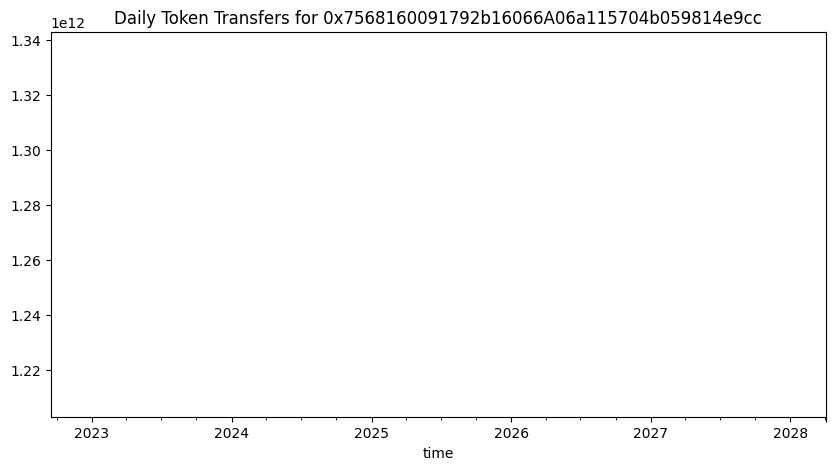

TypeError: cannot unpack non-iterable NoneType object

In [61]:
# Plot ERC-20 token transfer volume

erc20_txs, normal_txs = analyze_address("0x7568160091792b16066A06a115704b059814e9cc")


if not erc20_txs.empty:
    daily_erc20 = erc20_txs.set_index('time').resample('D')['token_value'].sum()
    daily_erc20.plot(label='ERC-20 Volume', figsize=(10,5))

# Plot ETH sent in normal txs
if not normal_txs.empty:
    daily_eth = normal_txs.set_index('time').resample('D')['value_eth'].sum()
    daily_eth.plot(label='ETH Volume')

plt.title(f"Daily Transfers for {address}")
plt.legend()
plt.tight_layout()
plt.show()

--- Analyzing address: 0x7568160091792b16066A06a115704b059814e9cc ---
Total ERC-20 transactions: 6
Top tokens transferred:
tokenSymbol
ZEUS    1.264656e+12 

Top receivers:
to
0x7568160091792b16066a06a115704b059814e9cc    5
0x055fb841cce69000fbaff2691ad39fa6e23826a1    1 

No interactions found with TornadoCash in ERC-20 transactions
No interactions found with Tokenlon in ERC-20 transactions
No interactions found with UniswapV2 in ERC-20 transactions
No interactions found with 1inch in ERC-20 transactions
No interactions found with TornadoCash in Normal transactions
No interactions found with Tokenlon in Normal transactions
Interactions found with UniswapV2 in Normal transactions (5 transactions)
No interactions found with 1inch in Normal transactions


/Users/emcsi/Documents/GitHub/Ethereum-Scam-Pattern-Analysis/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


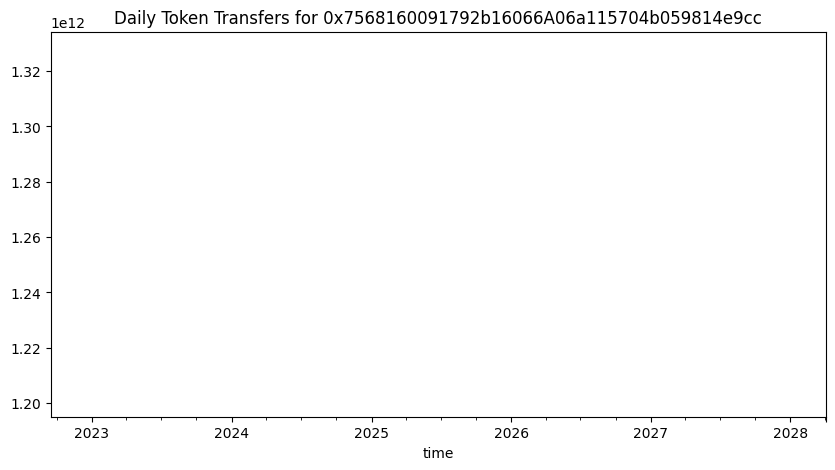



--- Analyzing address: 0xF58daEC3ABEe8b51F832b6bA3A06Fab2Aad3E0A8 ---
Total ERC-20 transactions: 37
Top tokens transferred:
tokenSymbol
MARS        16753921.49
POCHITA     12119582.18
WW3         11496916.82
RITA        11260309.80
STARBASE     9247065.73 

Top receivers:
to
0xf58daec3abee8b51f832b6ba3a06fab2aad3e0a8    24
0x64e7268a386cb337ffa6e0f605d6451cb447908e     2
0x55ec79ff76c8725998287a207a4dc76a86bb026b     1
0x93aace7b59510aa2679f9eccc998482a576e914f     1
0x1bff5f619028990ac01a9b7a46bbe34e91d04cde     1 

No interactions found with TornadoCash in ERC-20 transactions
No interactions found with Tokenlon in ERC-20 transactions
No interactions found with UniswapV2 in ERC-20 transactions
No interactions found with 1inch in ERC-20 transactions
No interactions found with TornadoCash in Normal transactions
No interactions found with Tokenlon in Normal transactions
Interactions found with UniswapV2 in Normal transactions (16 transactions)
No interactions found with 1inch in Normal

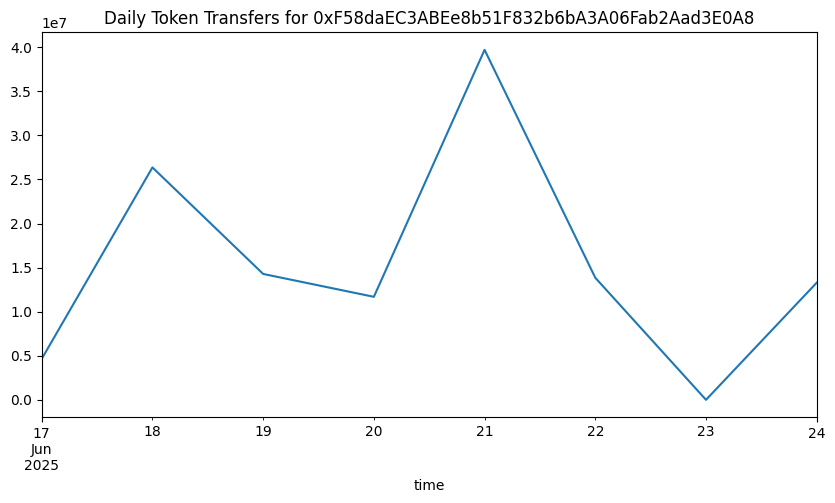



--- Analyzing address: 0xfd78EE919681417d192449715b2594ab58f5D002 ---
Total ERC-20 transactions: 10000
Top tokens transferred:
tokenSymbol
USDC                              5.824597e+08
claim rewards on t.ly/ethblaze    1.000000e+00 

Top receivers:
to
0xfd78ee919681417d192449715b2594ab58f5d002    5001
0x0000000000000000000000000000000000000000    4999 

No interactions found with TornadoCash in ERC-20 transactions
No interactions found with Tokenlon in ERC-20 transactions
No interactions found with UniswapV2 in ERC-20 transactions
No interactions found with 1inch in ERC-20 transactions
No interactions found with TornadoCash in Normal transactions
No interactions found with Tokenlon in Normal transactions
No interactions found with UniswapV2 in Normal transactions
No interactions found with 1inch in Normal transactions


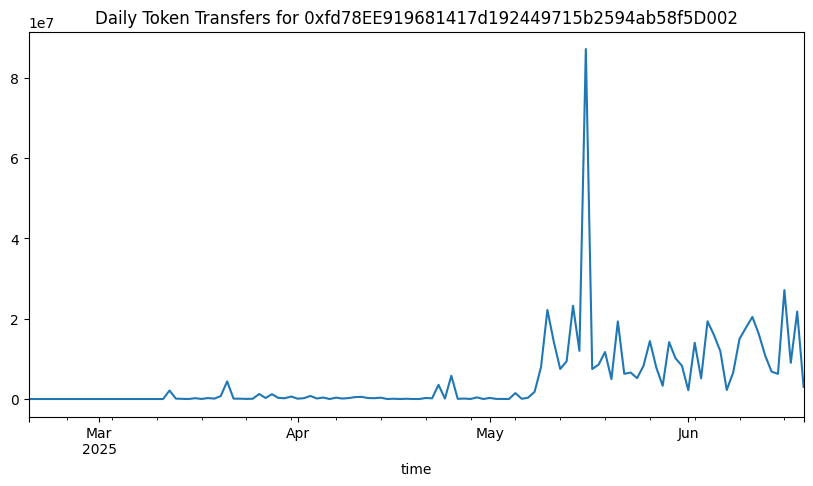



--- Analyzing address: 0xAbb07822F471773Ff00b9444308ceEB7cf0dACa7 ---
Total ERC-20 transactions: 1936
Top tokens transferred:
tokenSymbol
DAI            46653834.14
USDC           23225111.07
USDT           12945116.15
Kishui.net      2403500.00
Luxoshi.com      707090.00 

Top receivers:
to
0xabb07822f471773ff00b9444308ceeb7cf0daca7    1081
0x4a14347083b80e5216ca31350a2d21702ac3650d     302
0x88dcd15ba4920d1c5fd5812b17477f5aec8207a3      75
0x88d120bc315fffe0f52fd65f869d4038bad207a3      50
0x88df10b9d2e387d3a819e31332c005719d6207a3      27 

No interactions found with TornadoCash in ERC-20 transactions
Interactions found with Tokenlon in ERC-20 transactions (819 transactions)
No interactions found with UniswapV2 in ERC-20 transactions
No interactions found with 1inch in ERC-20 transactions
No interactions found with TornadoCash in Normal transactions
No interactions found with Tokenlon in Normal transactions
No interactions found with UniswapV2 in Normal transactions
No interaction

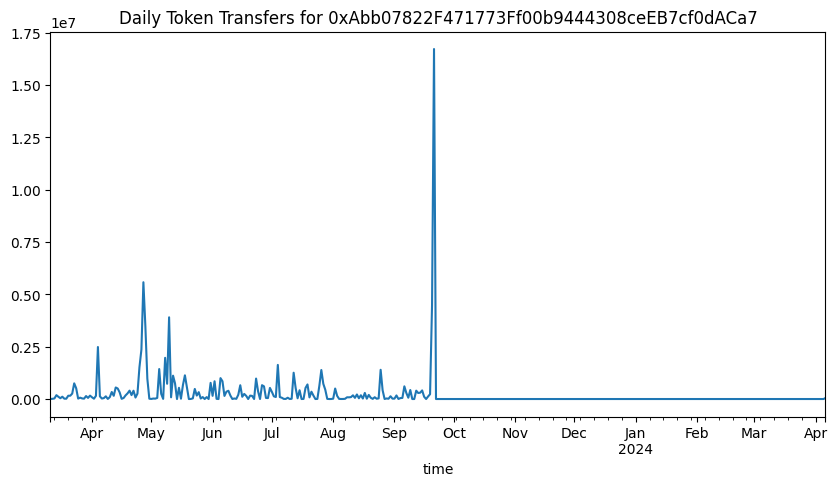



--- Analyzing address: 0xa42303EE9B2eC1DB7E2a86Ed6C24AF7E49E9e8B9 ---
Total ERC-20 transactions: 105
Top tokens transferred:
tokenSymbol
TORN                14981.21
DAI                 12459.73
ApeCoinV2.com       10254.00
USDT                 1173.64
$ AaveReward.com      800.00 

Top receivers:
to
0xa42303ee9b2ec1db7e2a86ed6c24af7e49e9e8b9    87
0x2fc93484614a34f26f7970cbb94615ba109bb4bf     7
0x12d92fed171f16b3a05acb1542b40648e7ced384     5
0x5ec192f4321ad41eaae5671afb777c75831104f9     5
0x05a3c4b1a99eced9ae4af4fd77cc04cb7bf965e0     1 

Interactions found with TornadoCash in ERC-20 transactions (22 transactions)
No interactions found with Tokenlon in ERC-20 transactions
No interactions found with UniswapV2 in ERC-20 transactions
No interactions found with 1inch in ERC-20 transactions
Interactions found with TornadoCash in Normal transactions (40 transactions)
No interactions found with Tokenlon in Normal transactions
No interactions found with UniswapV2 in Normal transactions
N

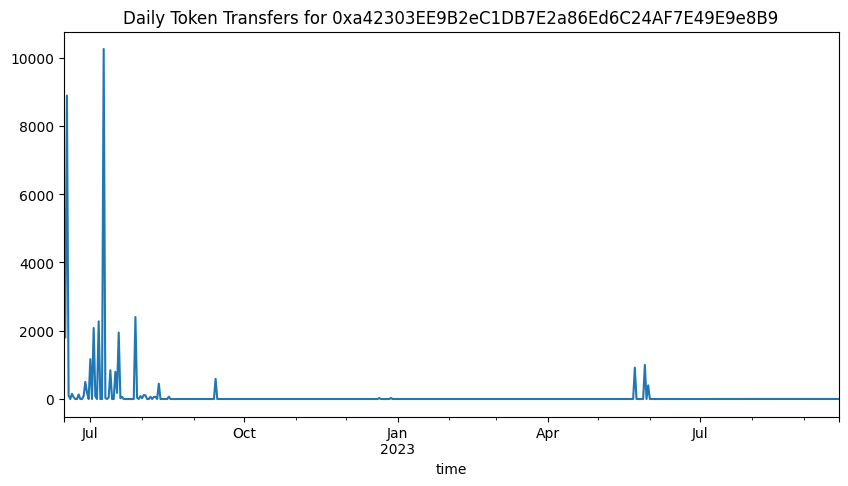

In [59]:
# Run analysis for all addresses
for addr in addresses:
    analyze_address(addr)
    print("\n" + "="*50 + "\n")
